# 2ª Entrega do Projeto [![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/SimpleANPR/anpr/blob/main/2a_Entrega_ANPR.ipynb)

Esse Jupyter Notebook contém uma demonstração da segunda etapa do projeto: algoritmos e técnicas de pré-processamento. O problema escolhido pela equipe foi o reconhecimento automático de placas veiculares. 

In [1]:
try:
  import google.colab
  IN_COLAB = True
except:
  IN_COLAB = False

In [2]:
if IN_COLAB:
    # Configurando o ambiente para execução no colab
    !git clone https://github.com/SimpleANPR/anpr
    %cd /content/anpr
    %pip install -r requirements.tx

## Dataset

O dataset selecionado foi o conjunto de imagens de benchmark utilizados pelo OpenALPR (https://github.com/openalpr/benchmarks). Ao todo, temos um total de 444 imagens anotados de veículos e suas placas.

In [3]:
from anpr.datasets.open_alpr import OpenALPRDataset
from matplotlib import pyplot as plt
import matplotlib.patches as patches
import pandas as pd
import plotly.express as px

In [4]:
# Acessando o dataset (realiza o download automático das imagens)
ds = OpenALPRDataset()
print(f'Quantidade total de imagens: {ds.total_images()}')

Quantidade total de imagens: 444


In [5]:
def show_image_with_plate(img):
    """Método utilitário que mostra uma
    imagem anotada do dataset OpenALPR.

    Args:
        img (OpenALPRImage): imagem anotada.
    """
    print(f'Placa: {img.plate_text}')
    _, ax = plt.subplots()
    ax.imshow(img.image)
    x, y, w, h = img.plate_rect
    ax.add_patch(patches.Rectangle((x, y), w, h, 
                                linewidth=1, 
                                edgecolor='r', 
                                facecolor='none'))

Placa: RK819AM


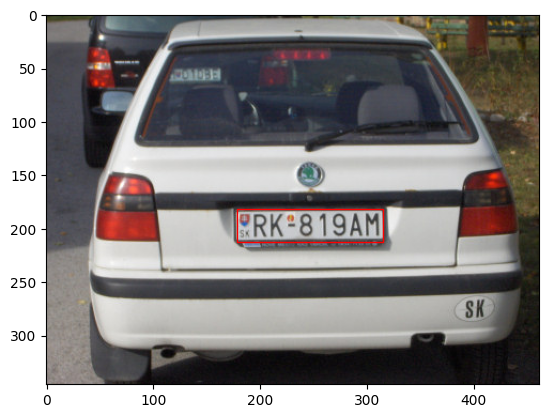

In [6]:
# Exemplo de uma imagem anotada do dataset
img = ds.image_at(200)
show_image_with_plate(img)

In [7]:
# Coletando medidas estatísticas do dataset
data = {
    'resolution': [],
    'plate_area': []
}

for i in range(ds.total_images()):
    annotated_img = ds.image_at(i)
    h, w, _ = annotated_img.image.shape
    _, _, p_w, p_h = annotated_img.plate_rect

    # Adicionando essa resolução
    target_res = f'{w}x{h}'
    data['resolution'].append(target_res)

    # Adicionando área normalizada
    image_area = h * w
    plate_area = p_w * p_h
    norm_area = plate_area / image_area
    data['plate_area'].append(round(norm_area * 100, 2))


In [8]:
# Histograma das resoluções do dataset
df = pd.DataFrame({'resolution': data['resolution']})
df = df.sort_values(by='resolution')
px.histogram(df, x='resolution')

# Da figura, conseguimos perceber que existe uma quantidade
#   variada de resoluções no dataset. Todavia, muitas imagens
#   possuem resolução 1280x720.

In [9]:
# Distribuição das áreas dos retângulos das placas
df = pd.DataFrame({'plate_area': data['plate_area']})
px.histogram(df, x='plate_area', nbins=10)

# A figura indica a % da área ocupada pela placa com relação
#   à área total da imagem. Conseguimos perceber que a grande maioria
#   das placas ocupa <5% da área total da imagem, todavia
#   existem algumas imagem onde a placa ocupa >15% da área
#   total.

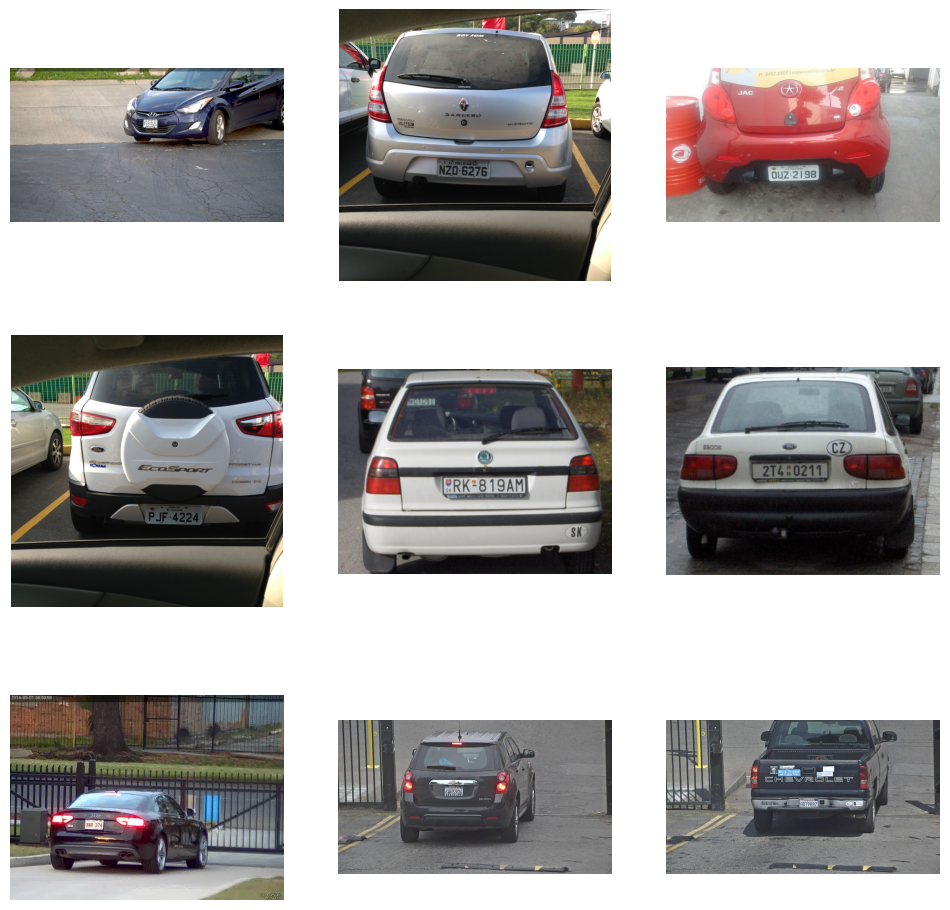

In [10]:
# Exemplos de imagens
imgs = [ds.image_at(i).image 
        for i in [0, 50, 80, 100, 200, 
                  240, 300, 400, 440]]
fig, axs = plt.subplots(3, 3,
                        figsize=(12, 12),
                        facecolor='w',
                        edgecolor='k')
axs = axs.ravel()

for i, img_ in enumerate(imgs):
  axs[i].axis("off")
  axs[i].imshow(img_)


## Pré-processamento: Escala de Cinza


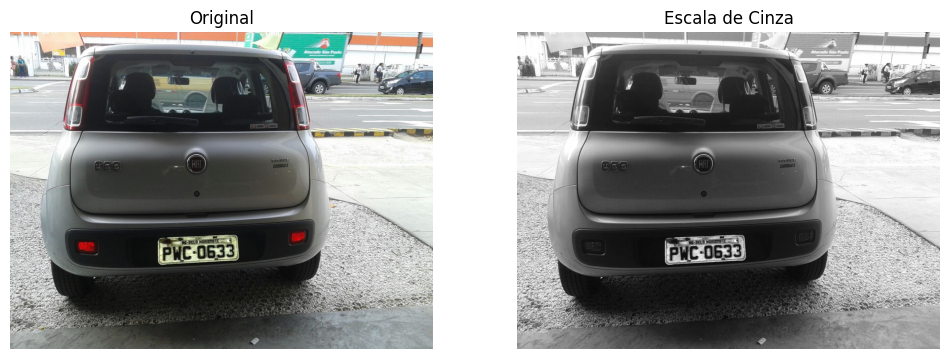

In [11]:
from anpr.generic.grayscale import GrayScale

img = ds.image_at(122).image
imgs = {
  'Original': img,
  'Escala de Cinza': GrayScale().process(img)
}

fig, axs = plt.subplots(1, 2,
                        figsize=(12, 6),
                        facecolor='w',
                        edgecolor='k')
axs = axs.ravel()
for i, (k, v) in enumerate(imgs.items()):
  axs[i].set_title(k)
  axs[i].axis("off")
  cmap = None

  if i > 0:
    cmap = 'gray'

  axs[i].imshow(v, cmap=cmap)

## Pré-processamento: Redução de Ruído e Suavização

In [12]:
import math

from anpr.generic.filter_bilateral import FilterBilateral
from anpr.generic.filter_gaussian import FilterGaussian
from anpr.generic.filter_mean import FilterMean
from anpr.generic.filter_median import FilterMedian
from anpr.generic.filter_nlm import FilterNLM

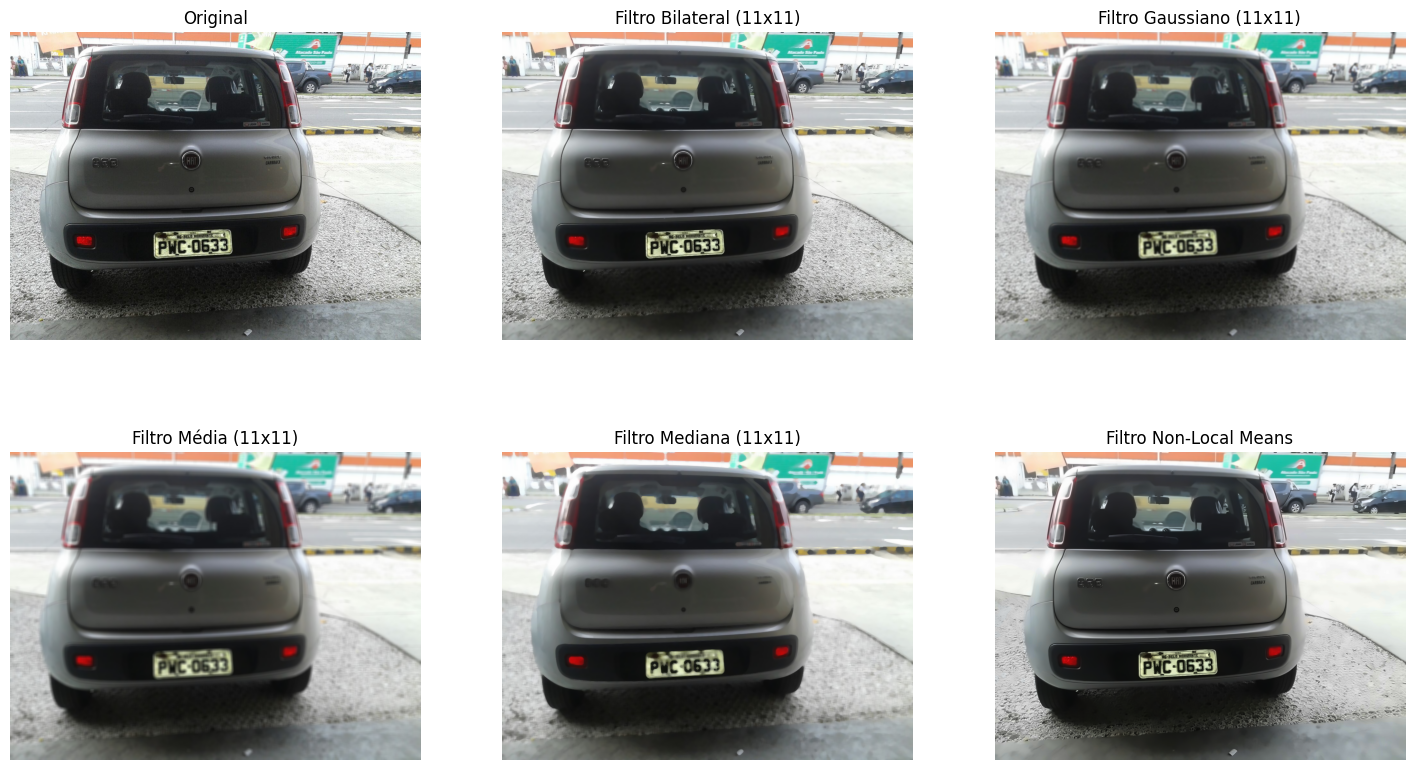

In [13]:
img = ds.image_at(122).image
kernel_size = 11
k = f'{kernel_size}x{kernel_size}'
imgs = {
    'Original': img,
    f'Filtro Bilateral ({k})': FilterBilateral(kernel_size,
                                               75,
                                               75).process(img),
    f'Filtro Gaussiano ({k})': FilterGaussian(kernel_size).process(img),
    f'Filtro Média ({k})': FilterMean(kernel_size).process(img),
    f'Filtro Mediana ({k})': FilterMedian(kernel_size).process(img),
    f'Filtro Non-Local Means': FilterNLM(kernel_size,
                                         kernel_size).process(img)

}

cols = 3
rows = math.ceil(len(imgs) / cols)
fig, axs = plt.subplots(rows, cols,
                        figsize=(6 * cols, 5 * rows),
                        facecolor='w',
                        edgecolor='k')
axs = axs.ravel()
for i, (k, v) in enumerate(imgs.items()):
    axs[i].set_title(k)
    axs[i].axis("off")
    axs[i].imshow(v)

## Pré-processamento: Ajuste de Brilho e Contraste

In [14]:
from anpr.generic.histogram_normalization import HistogramNormalization
from anpr.generic.contrast import Contrast
from anpr.generic.brightness import Brightness

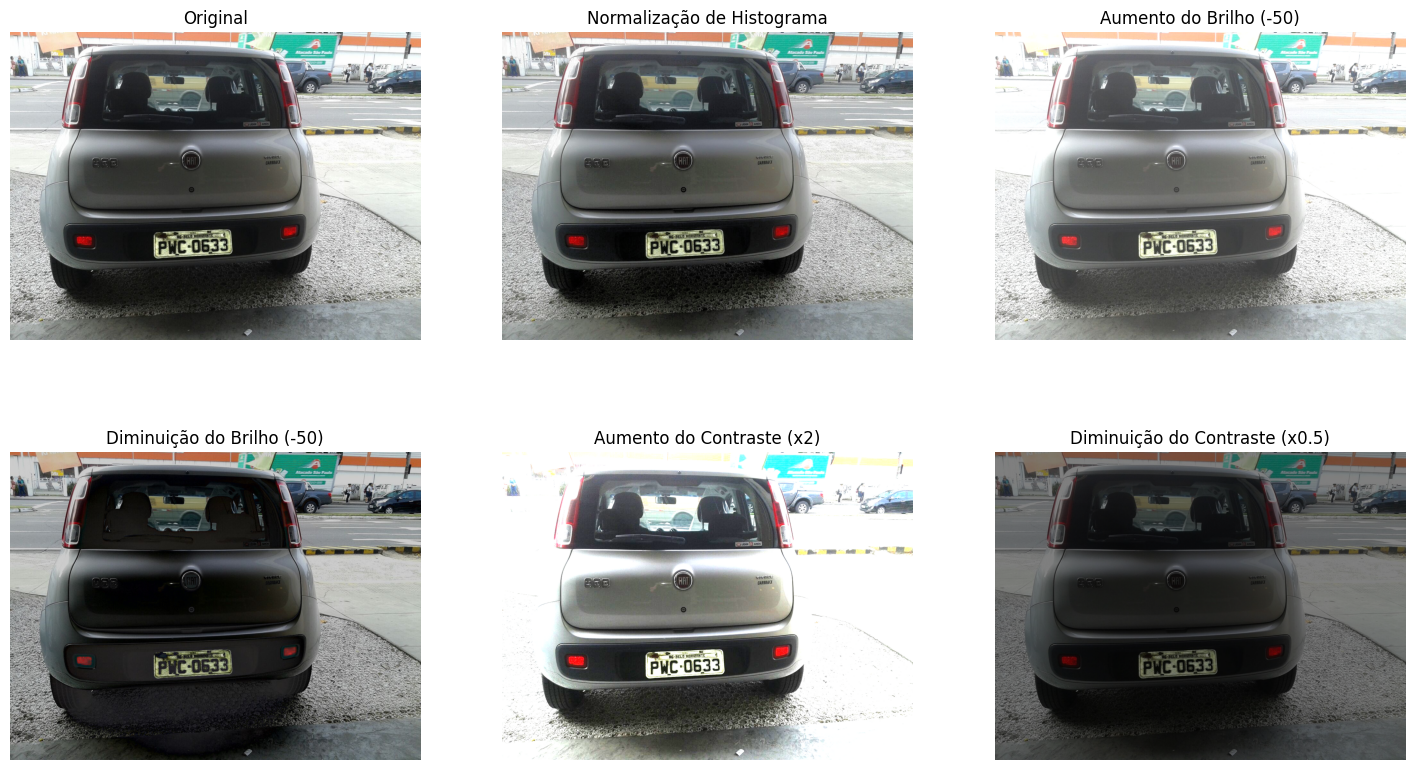

In [15]:
img = ds.image_at(122).image
imgs = {
    'Original': img,
    'Normalização de Histograma': HistogramNormalization().process(img),
    'Aumento do Brilho (-50)': Brightness(50).process(img),
    'Diminuição do Brilho (-50)': Brightness(-50).process(img),
    'Aumento do Contraste (x2)': Contrast(2).process(img),
    'Diminuição do Contraste (x0.5)': Contrast(0.5).process(img)
}

cols = 3
rows = math.ceil(len(imgs) / cols)
fig, axs = plt.subplots(rows, cols,
                        figsize=(6 * cols, 5 * rows),
                        facecolor='w',
                        edgecolor='k')
axs = axs.ravel()
for i, (k, v) in enumerate(imgs.items()):
    axs[i].set_title(k)
    axs[i].axis("off")
    axs[i].imshow(v)

## Interpolação: Aumentando/Diminuindo Imagens

In [16]:
from anpr.interpolation.nearest import Nearest
from anpr.interpolation.lanczos import Lanczos
from anpr.interpolation.bilinear import Bilinear
from anpr.interpolation.bicubic import Bicubic

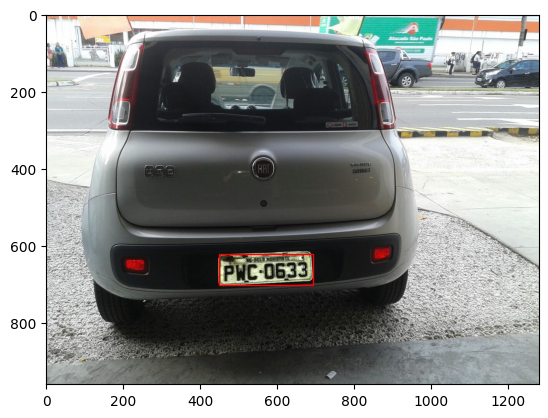

In [17]:
# Carregando a imagem
image = ds.image_at(122)
img = image.image
x, y, w, h = image.plate_rect

# Mostrando a imagem original com a anotação da placa
fig, ax = plt.subplots()
ax.imshow(img)
ax.add_patch(patches.Rectangle((x, y), w, h, 
                               linewidth=1, 
                               edgecolor='r', 
                               facecolor='none'))

Resolução da placa: (79, 244, 3)


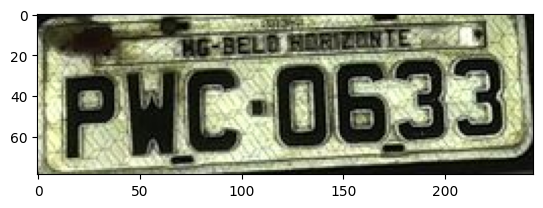

In [18]:
# Extraindo apenas a placa
plate = img[y:y+h,x:x+w]
print(f'Resolução da placa: {plate.shape}')
plt.imshow(plate)

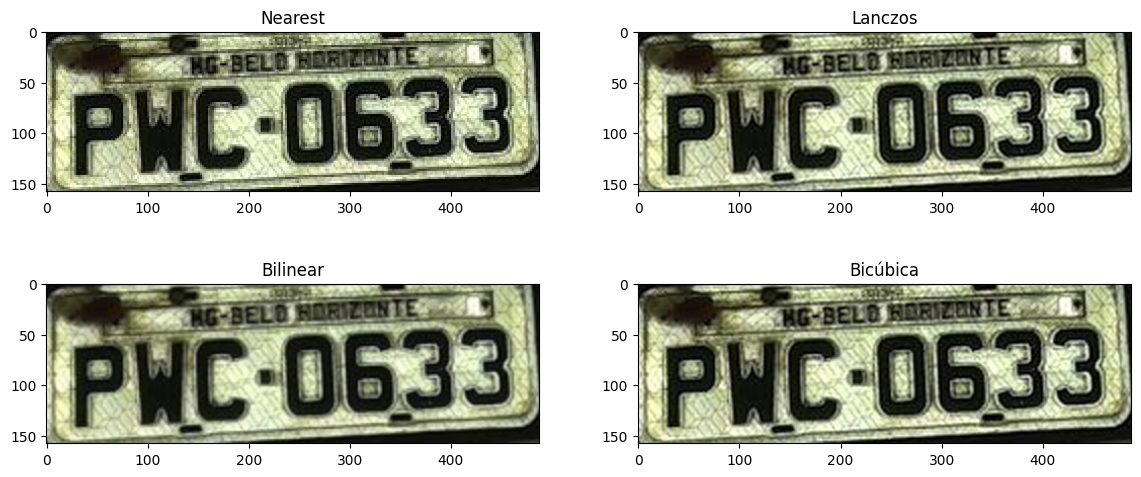

In [19]:
# Redimensionando a placa para uma resolução maior
ph, pw, _ = plate.shape
target_res = (2*pw, 2*ph)
imgs = {
    'Nearest': Nearest(target_res).resize(plate),
    'Lanczos': Lanczos(target_res).resize(plate),
    'Bilinear': Bilinear(target_res).resize(plate),
    'Bicúbica': Bicubic(target_res).resize(plate)
}


cols = 2
rows = math.ceil(len(imgs) / cols)
fig, axs = plt.subplots(rows, cols,
                        figsize=(7 * cols, 3 * rows),
                        facecolor='w',
                        edgecolor='k')
axs = axs.ravel()

for i, (k, v) in enumerate(imgs.items()):
  axs[i].set_title(k)
  axs[i].imshow(v)

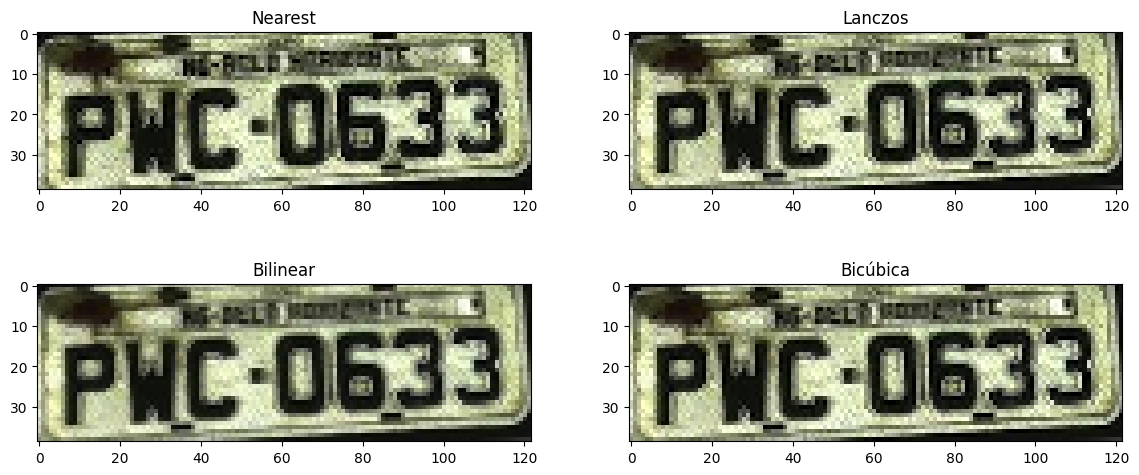

In [20]:
# Redimensionando a placa para uma resolução menor
ph, pw, _ = plate.shape
target_res = (pw // 2, ph // 2)
imgs = {
    'Nearest': Nearest(target_res).resize(plate),
    'Lanczos': Lanczos(target_res).resize(plate),
    'Bilinear': Bilinear(target_res).resize(plate),
    'Bicúbica': Bicubic(target_res).resize(plate)
}


cols = 2
rows = math.ceil(len(imgs) / cols)
fig, axs = plt.subplots(rows, cols,
                        figsize=(7 * cols, 3 * rows),
                        facecolor='w',
                        edgecolor='k')
axs = axs.ravel()

for i, (k, v) in enumerate(imgs.items()):
  axs[i].set_title(k)
  axs[i].imshow(v)

## Pré-processamento: Filtros Morfológicos

In [21]:
from anpr.generic.morphological_closing import MorphologicalClosing
from anpr.generic.morphological_opening import MorphologicalOpening
import cv2

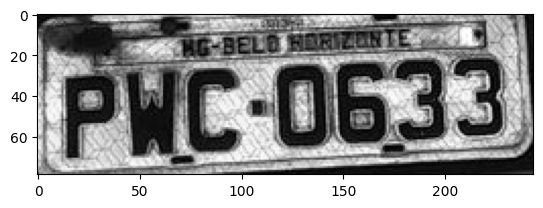

In [22]:
img = GrayScale().process(plate)
plt.imshow(img, cmap='gray')

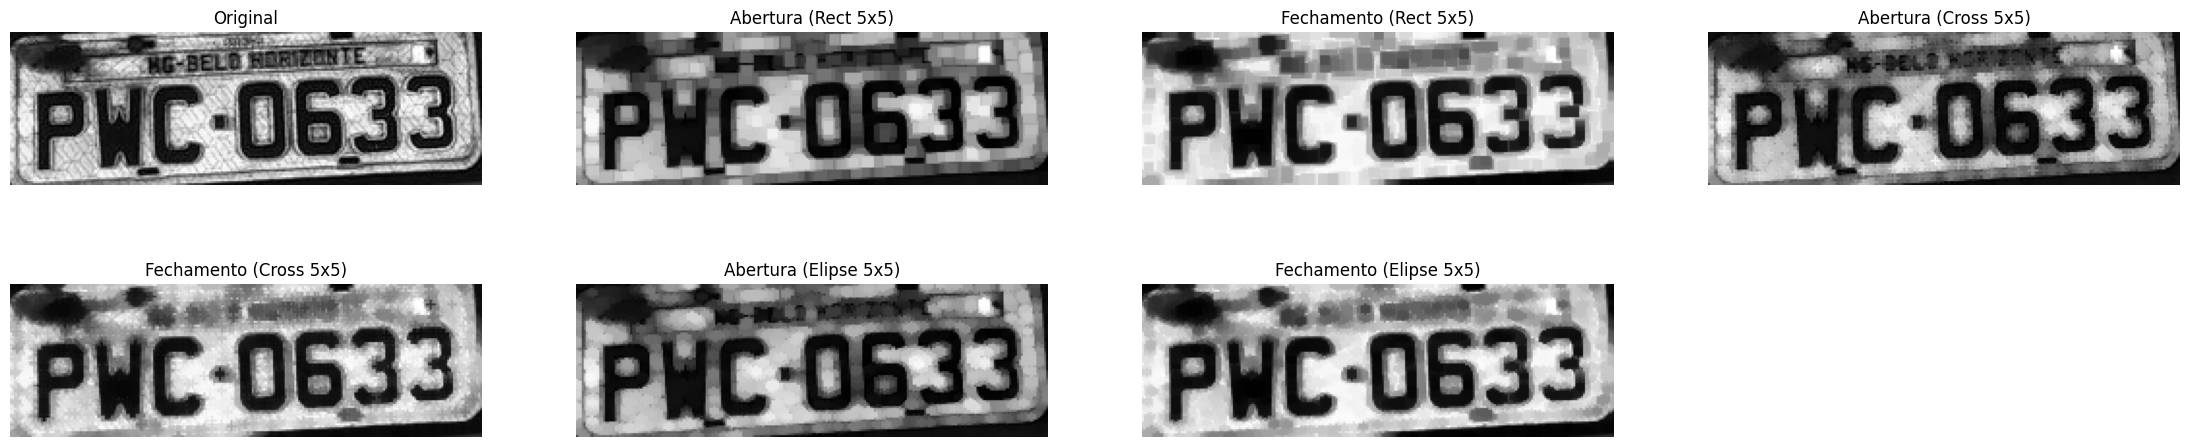

In [23]:
size = (5, 5)
rect = cv2.getStructuringElement(cv2.MORPH_RECT,
                                 size)
cross = cv2.getStructuringElement(cv2.MORPH_CROSS,
                                  size)
ellipse = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,
                                     size)
size = f'{size[0]}x{size[1]}'
imgs = {
    'Original': img,
    f'Abertura (Rect {size})': MorphologicalOpening(rect).process(img),
    f'Fechamento (Rect {size})': MorphologicalClosing(rect).process(img),
    f'Abertura (Cross {size})': MorphologicalOpening(cross).process(img),
    f'Fechamento (Cross {size})': MorphologicalClosing(cross).process(img),
    f'Abertura (Elipse {size})': MorphologicalOpening(ellipse).process(img),
    f'Fechamento (Elipse {size})': MorphologicalClosing(ellipse).process(img)
}


cols = 4
rows = math.ceil(len(imgs) / cols)
fig, axs = plt.subplots(rows, cols,
                        figsize=(7 * cols, 3 * rows),
                        facecolor='w',
                        edgecolor='k')
fig.delaxes(axs[1, 3])
axs = axs.ravel()

for i, (k, v) in enumerate(imgs.items()):
    axs[i].set_title(k)
    axs[i].set_axis_off()
    axs[i].imshow(v, cmap='gray')